## Creating Example Cutouts of Our Visualisations

### Imports

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2 as cv
import os

from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs import WCS
from astropy.table import Table

from astropy.visualization import ZScaleInterval, LinearStretch

import numpy as np
from scipy import special
from scipy.stats import kstwobign, anderson

In [2]:
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
fig_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'
fits_folder = 'E:/cosmos-fits'
cosmos_folder = 'E:/cosmos-data'

In [3]:
df_src = pd.read_csv(f'{data_folder}/cosmos-primary-data.csv', index_col = 0).reset_index().rename(columns = {'index' : 'SourceID'})[['SourceID', 'ID', 'ALPHA_J2000', 'DELTA_J2000', 'ez_z_phot', 'lp_zBEST', 'ez_sfr', 'lp_mass_best']]

In [4]:
df_src

,SourceID,ID,ALPHA_J2000,DELTA_J2000,ez_z_phot,lp_zBEST,ez_sfr,lp_mass_best
0,4000705532455,816891,150.679846,2.196543,0.519525,0.5304,5.896951e-01,9.28590
1,4000705532984,857121,150.673667,2.226291,0.219858,0.2235,2.490057e-01,10.49288
2,4000705533312,873195,150.668102,2.242849,0.346519,0.3024,3.339377e-01,10.18078
3,4000705533383,861738,150.645118,2.237538,0.619803,0.6224,2.500856e-01,9.36051
4,4000705539529,1284864,149.686223,2.637412,0.705821,0.6984,9.017610e-01,10.17034
...,...,...,...,...,...,...,...,...
3781,6000535064806,1041748,150.435644,2.404769,1.091646,NaN,6.479975e-01,9.08741
3782,6000535121007,997393,149.712229,2.359027,11.935175,NaN,1.000000e+20,NaN
3783,6000535781610,1231637,150.428931,2.588176,0.538722,0.4988,-8.008846e-01,8.52516
3784,6000535864481,1042682,150.505365,2.407106,NaN,1.4406,NaN,6.95391


In [5]:
df_red_tmp = df_src.query('ez_sfr < 10')
df_red = df_red_tmp.query('lp_mass_best > 6.5')[['SourceID', 'ID', 'ALPHA_J2000', 'DELTA_J2000', 'ez_z_phot', 'lp_zBEST']]

In [6]:
df_clsf = pd.read_csv(f'{data_folder}/secondaries-identified.csv', index_col = 0).reset_index().rename(columns = {'index' : 'ORyan23_ID', "0" : 'clsf'})

In [7]:
df_clsf.query('ORyan23_ID == 4000717343349')

,ORyan23_ID,clsf
104,4000717343349,n


In [8]:
with fits.open(f'{cosmos_folder}/COSMOS2020_CLASSIC_R1_v2.1_p3.fits.gz') as hdul:
    data = hdul[1].data

In [9]:
df_src.query('ez_z_phot < 0.1')

,SourceID,ID,ALPHA_J2000,DELTA_J2000,ez_z_phot,lp_zBEST,ez_sfr,lp_mass_best
100,4000717343349,792598,149.525038,2.173961,0.091659,NaN,-1.523659,9.85036
162,4000729423793,836256,150.455059,2.210010,0.095640,NaN,-1.253883,8.56171
164,4000729424141,851230,150.468643,2.222646,0.091443,NaN,-0.636607,8.28768
179,4000734197418,1122092,150.237476,2.480174,0.029816,0.0000,-6.029353,8.82147
497,4000780461313,1228875,150.458527,2.582444,0.049862,0.0106,-1.642748,6.28336
...,...,...,...,...,...,...,...,...
3756,6000266757037,1062168,150.099293,2.425904,0.060390,NaN,-3.446040,6.33853
3759,6000311257352,1248993,150.203863,2.606050,0.091692,1.4411,-3.186437,7.19676
3764,6000443709301,1019667,150.097619,2.384458,0.076675,0.3141,-3.978776,5.10945
3768,6000513404870,910711,150.519330,2.284680,0.028114,NaN,-4.737973,8.62887


In [10]:
tmp_3 = df_clsf.query('clsf == "n"').sample(1)
tmp_3

,ORyan23_ID,clsf
1621,4000990953378,n


In [11]:
ids = [4000717343349, 4001279692135, 4001123675610, 4001199188073, 4000956352246]

In [12]:
ids

[4000717343349, 4001279692135, 4001123675610, 4001199188073, 4000956352246]

In [13]:
def picking_z(ez_z, lp_z):
    if np.isnan(ez_z):
        if not np.isnan(lp_z):
            return lp_z
        else:
            return np.nan
    
    if np.isnan(lp_z):
        if not np.isnan(ez_z):
            return ez_z
        else:
            return np.nan
    
    if lp_z < ez_z:
        return lp_z
    elif ez_z <= lp_z:
        return ez_z
    else:
        return 'what'

In [14]:
def getting_secondary(ra, dec, z, prim_id):
    record = data[(data['ALPHA_J2000'] > ra - (15 / (60*60))) & (data['ALPHA_J2000'] < ra + (15 / (60*60))) & (data['DELTA_J2000'] > dec - (15 / (60*60))) & (data['DELTA_J2000'] < dec + (15 / (60*60)))]
    
    df = Table(record).to_pandas()[['ID', 'ALPHA_J2000', 'DELTA_J2000', 'ez_z_phot', 'lp_zBEST']]
    
    df_z = (
        df
        .assign(redshift = df.apply(lambda row: picking_z(row.ez_z_phot, row.lp_zBEST), axis = 1))
        .drop(columns = ['ez_z_phot', 'lp_zBEST'])
        .dropna()
        .query('ID != @prim_id')
    )   
    
    return df_z

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in log10
C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in log10
C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in log10
C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in log10
C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in log10


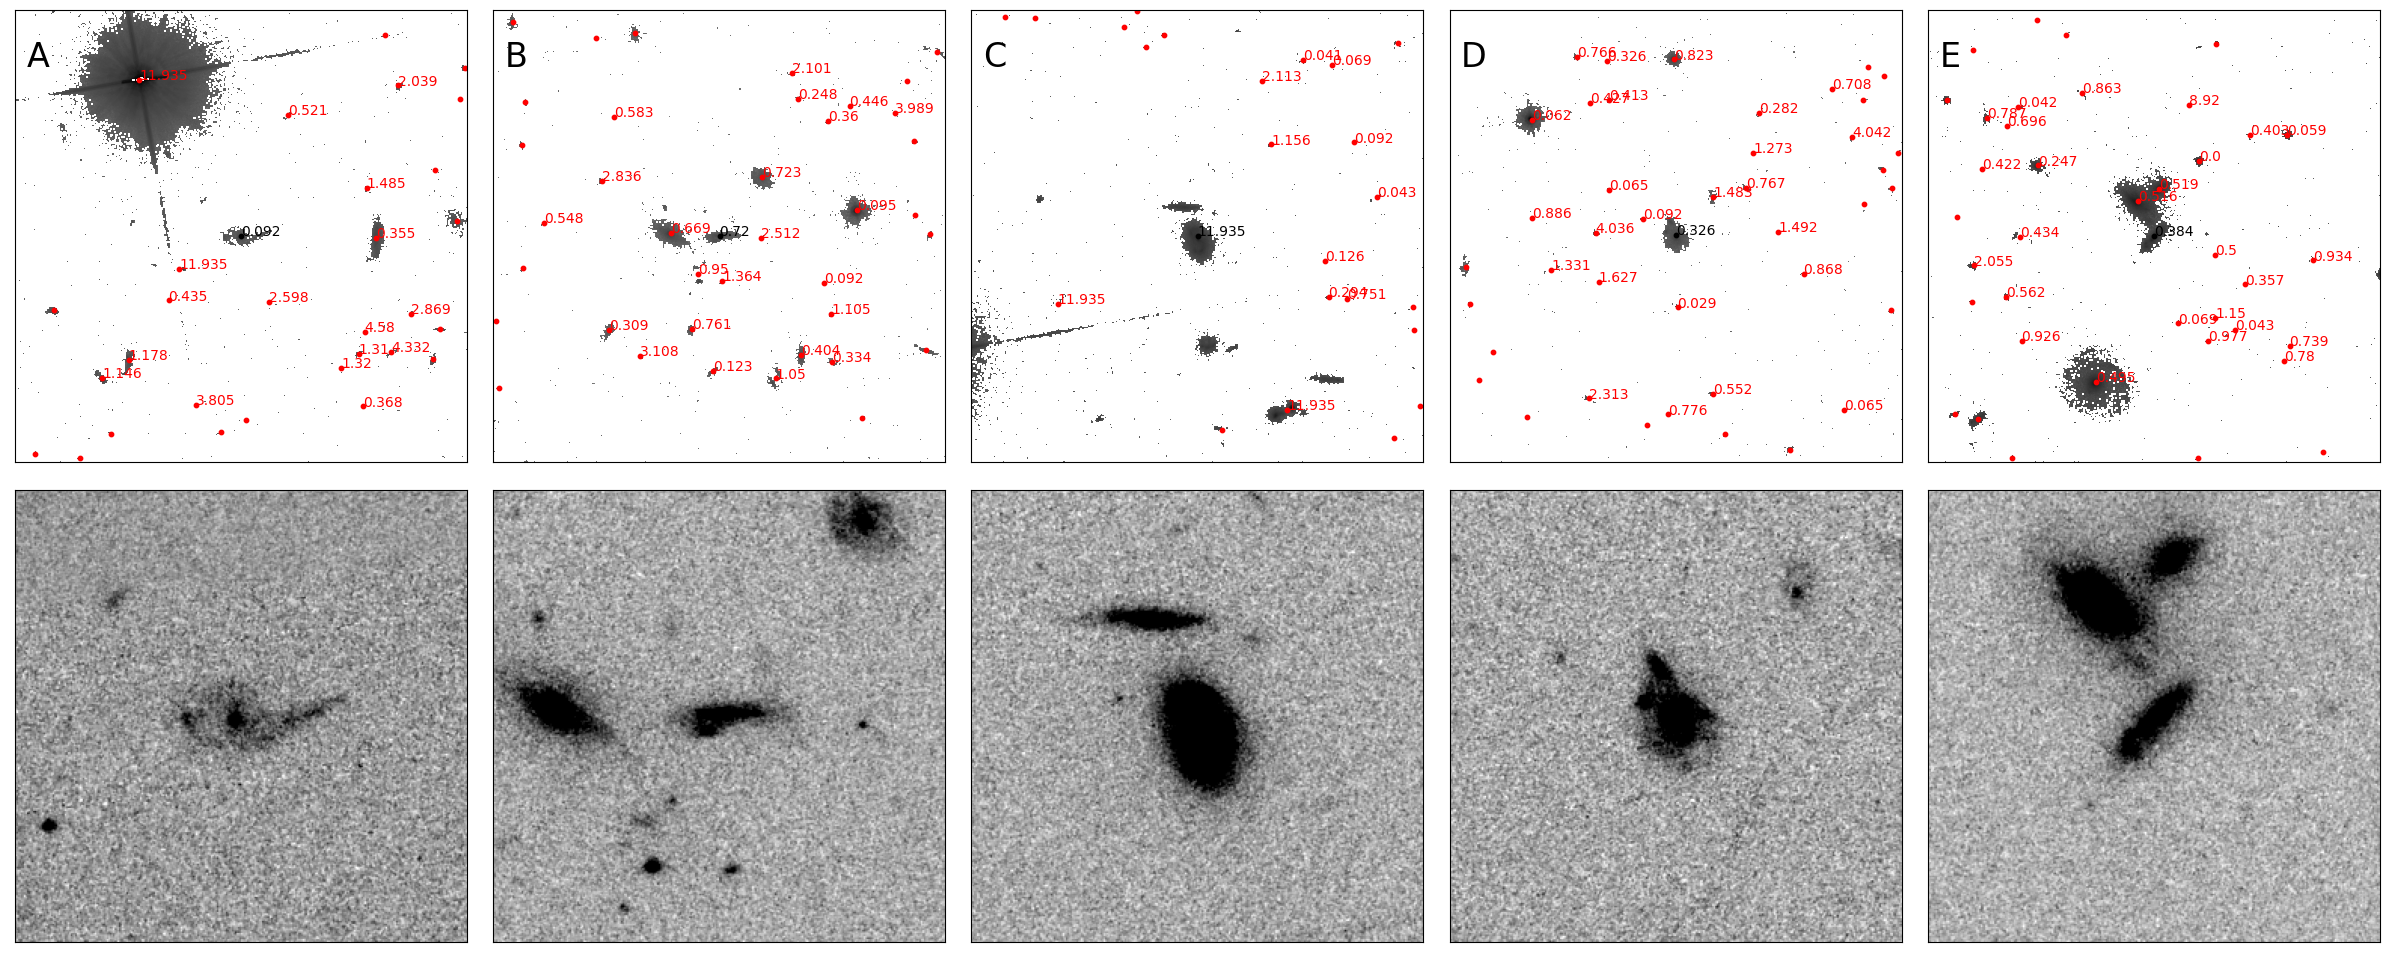

In [22]:
fig, axes = plt.subplots(ncols = 5, nrows = 2, figsize = (24,10))
letters = ['A', 'B','C','D','E']
for i in range(5):
    sourceid = ids[i]
    file_path = f'{fits_folder}/{sourceid}.fits'
    assert os.path.exists(file_path)
    
    ra = df_src.query('SourceID == @sourceid')['ALPHA_J2000'].iloc[0]
    dec = df_src.query('SourceID == @sourceid')['DELTA_J2000'].iloc[0]
    z_ez = df_src.query('SourceID == @sourceid')['ez_z_phot'].iloc[0]
    z_lp = df_src.query('SourceID == @sourceid')['lp_zBEST'].iloc[0]
    id_str = df_src.query('SourceID == @sourceid')['ID'].iloc[0]
    
    redshift = picking_z(z_ez, z_lp)
        
    prim_coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'fk5')
    
    df_secs = getting_secondary(ra, dec, redshift, id_str)
        
    with fits.open(file_path) as hdul:
        im_data = hdul[0].data
        header = hdul[0].header
    
    w = WCS(header)
        
    df_coords = (
        df_secs
        .assign(coords = df_secs.apply(lambda row: SkyCoord(ra = row.ALPHA_J2000 * u.deg, dec = row.DELTA_J2000 * u.deg, frame = 'fk5'), axis = 1))
    )
    
    id_list = list(df_coords.ID)
    coords_list = list(df_coords.coords)
    z_list = list(df_coords.redshift)
    
    pixs_list = []
    for j in coords_list:
        pixs_list.append(skycoord_to_pixel(j, w, origin = 0))
    pixs_arr = np.array(pixs_list)
    
    prim_pix = np.array(skycoord_to_pixel(prim_coord, w, origin = 0))
    
    axes[0,i].imshow(np.log10(im_data), origin = 'lower', cmap = 'gray_r')
    axes[0,i].scatter(prim_pix[0], prim_pix[1], s = 10, color='black')
    axes[0,i].annotate(np.round(redshift, 3), (prim_pix[0], prim_pix[1]), color = 'black')
    axes[0,i].scatter(pixs_arr[:,0], pixs_arr[:,1], s = 10, color = 'red')
    for j, txt in enumerate(z_list):
        if pixs_arr[j,0] > im_data.shape[0] - 100 or pixs_arr[j,0] < 100:
            continue
        elif pixs_arr[j,1] > im_data.shape[0] - 100 or pixs_arr[j,1] < 100:
            continue
        axes[0,i].annotate(f'{np.round(txt, 3)}', (pixs_arr[j,0], pixs_arr[j,1]), color = 'red')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    
    cutout = im_data[350:650,350:650]
    
    interval = ZScaleInterval(nsamples = 5000)
    stretch = LinearStretch()
    
    cutout_norm = stretch(interval(cutout))
    
    axes[1,i].imshow(cutout_norm, origin = 'lower', cmap = 'gray_r')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])
    
    axes[0,i].text(25,875, letters[i], fontsize=24)
    
fig.tight_layout()
fig.savefig(f'{fig_folder}/cutouts_ex.pdf', bbox_inches = 'tight')
plt.show()

Remember, from left to right these are supposed to be:
        
        Unknown secondary
        Clear secondary
        Not Merger
        Null redshift
        Incorrect Primary